In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.12.0


In [2]:
mnist = keras.datasets.mnist
(train_images, _), (_, _) = mnist.load_data()

print(train_images.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


In [0]:
train_images = train_images / 255

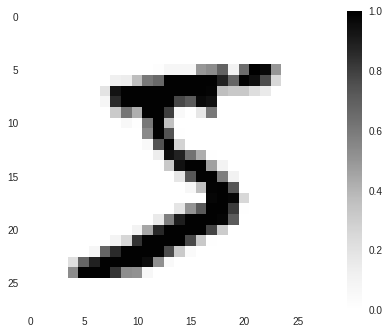

In [4]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.gca().grid(False)

In [0]:
generator = keras.Sequential([
    keras.layers.Dense(256, input_shape=(100,), activation=tf.nn.relu),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.Dense(1024, activation=tf.nn.relu),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.Dense(28 * 28, activation='tanh'),
    keras.layers.Reshape((28, 28))
])

generator.compile(optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5, decay=8e-8),
                  loss='binary_crossentropy')

In [0]:
discriminator = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(28 * 28, input_shape=(28, 28), activation=tf.nn.relu),
    keras.layers.Dense((28 * 28) / 2, activation=tf.nn.relu),
    keras.layers.Dense(1, activation='sigmoid')
])

discriminator.compile(optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5, decay=8e-8),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [0]:
discriminator.trainable = False

adversarial_model = keras.Sequential([
    generator,
    discriminator
])

adversarial_model.compile(optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5, decay=8e-8),
                          loss='binary_crossentropy')

In [0]:
epochs = 5
batch_size = 32

batches = train_images.shape[0] // batch_size

for epoch in range(epochs):
    for batch in range(batches):
        
        # Train the discriminator
        
        noise = np.random.normal(0, 1, (batch_size // 2, 100))
        fake_images = generator.predict(noise)
        fake_labels = np.zeros((batch_size // 2, 1))
        
        sample_indicies = np.random.randint(0, train_images.shape[0], batch_size // 2)
        real_images = train_images[sample_indicies]
        real_labels = np.ones((batch_size // 2, 1))
        
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
        
        # Train the generator
        
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = adversarial_model.train_on_batch(noise, np.ones((batch_size, 1)))
        
        # Logging output
        
        print('Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]' % (epoch, batch, batches, d_loss[0], 100 * d_loss[1], g_loss))